<a href="https://colab.research.google.com/github/sameer-nema/Introduction-to-Machine-Learning/blob/master/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Necessary Libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# setup gpu 
# !nvidia-smi
# tf.test.is_gpu_available()
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
# Importing Dataset
data = []
label = []
Files = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
label_val = 0

for files in Files:
    # cpath = os.path.join("C:/Users/pc/Desktop/Internship Work/Week - 4/Task - 16/COVID-19_Radiography_Dataset", files)
    cpath = os.path.join("/content/drive/MyDrive/COVID-19_Radiography_Dataset", files)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
        image_array = cv2.resize(image_array, (70, 70))
        data.append(image_array)
        label.append(label_val)
    label_val = label_val+1

In [4]:
# Transforming to Numpy Array
X = np.asarray(data)
y = np.asarray(label)

In [5]:
# Shuffling Dataset Values
X, y = shuffle(X, y)

In [6]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Printing the Shapes
print('Shape of X_train is {}'.format(X_train.shape))
print('Shape of X_test is {}'.format(X_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of X_train is (16931, 70, 70, 3)
Shape of X_test is (4233, 70, 70, 3)
Shape of y_train is (16931,)
Shape of y_test is (4233,)


In [8]:
# Normalizing Training Set
X_train=X_train/255
X_test=X_test/255

# Categorizing Testing Set
y_train_cat=to_categorical(y_train,4)
y_test_cat=to_categorical(y_test,4)

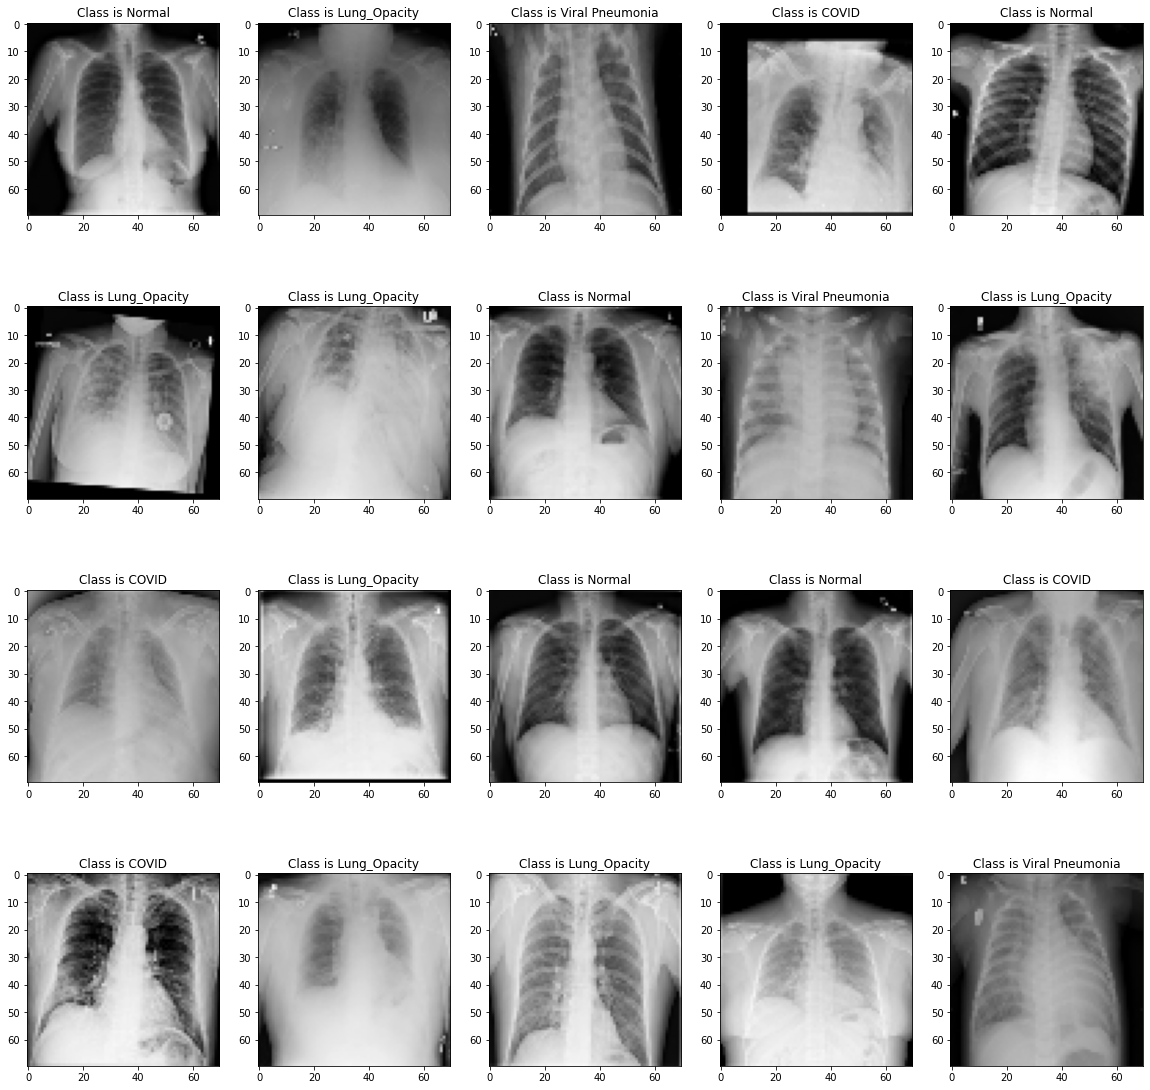

In [ ]:
# Visualizing the Data

X_train__ = X_train.reshape(X_train.shape[0], 70, 70, 3)

fig, axis = plt.subplots(4, 5, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train_cat[i].argmax()
    classname = Files[digit]
    ax.set(title = "Class is {:}".format(classname))

In [ ]:
# Bulding the First CNN Model
CNN_Model1=Sequential()

CNN_Model1.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(70,70,3)))
CNN_Model1.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))
CNN_Model1.add(BatchNormalization())

CNN_Model1.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
CNN_Model1.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))
CNN_Model1.add(BatchNormalization())   

CNN_Model1.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))

CNN_Model1.add(Flatten())
CNN_Model1.add(BatchNormalization())
CNN_Model1.add(Dense(512,activation="relu"))
CNN_Model1.add(Dense(4,activation="softmax"))

CNN_Model1.summary()

CNN_Model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 66, 66, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 33, 33, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 128)       1

In [16]:
# LEARNING RATE REDUCTION
learningRateReduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7,
                                            mode='auto',
                                            # min_delta=0.01,
                                            )

# EARLY STOPPING
earlyStopping = EarlyStopping(monitor="val_accuracy", 
                   min_delta=0.01, 
                   patience=10, 
                   verbose=1, 
                   mode='auto')

In [ ]:
# MODEL CHECKPOINT - CNN_Model1
modelCheckpoint = ModelCheckpoint(monitor="val_accuracy", 
                      filepath="/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/CNN_Model1.h5", 
                      verbose=1, 
                      save_best_only=True, 
                      mode='auto') 

callBack = [learningRateReduction, earlyStopping, modelCheckpoint]

In [ ]:
# Training the First CNN Model
CNN1_history=CNN_Model1.fit(X_train,
                  y_train_cat,
                  epochs=50,
                  batch_size=16,
                  validation_data=(X_test,y_test_cat),
                  verbose=1,
                  callbacks=callBack)

Epoch 1/50
1059/1059 [==============================] - ETA: 0s - loss: 1.6397 - accuracy: 0.7033
Epoch 1: val_accuracy improved from -inf to 0.72384, saving model to /content/drive/MyDrive/BestModel/CNN_Model1.h5
1059/1059 [==============================] - 43s 41ms/step - loss: 1.6397 - accuracy: 0.7033 - val_loss: 0.7278 - val_accuracy: 0.7238 - lr: 0.0010
Epoch 2/50
1059/1059 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.7917
Epoch 2: val_accuracy did not improve from 0.72384
1059/1059 [==============================] - 37s 35ms/step - loss: 0.5601 - accuracy: 0.7917 - val_loss: 4.0669 - val_accuracy: 0.3222 - lr: 0.0010
Epoch 3/50
1058/1059 [============================>.] - ETA: 0s - loss: 0.4708 - accuracy: 0.8282
Epoch 3: val_accuracy did not improve from 0.72384
1059/1059 [==============================] - 40s 38ms/step - loss: 0.4708 - accuracy: 0.8282 - val_loss: 1.7553 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 4/50
1059/1059 [======================

In [ ]:
# Loading the First CNN Model
CNN_Model1 = tf.keras.models.load_model('/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/CNN_Model1.h5')

In [9]:
# Function for Visualizing Fitting History
def plotmodelhistory(CNN_history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    
    axs[0].plot(CNN_history.history['accuracy']) 
    axs[0].plot(CNN_history.history['val_accuracy']) 
    axs[0].grid()
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'testing'], loc='upper left')
    
    axs[1].plot(CNN_history.history['loss']) 
    axs[1].plot(CNN_history.history['val_loss']) 
    axs[1].grid()
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    #axs[1].set_ylim([0.0,3.5])
    axs[1].legend(['train', 'testing'], loc='upper left')
    plt.show()

In [10]:
# Functions for Confusion Matrix

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    im = ax.imshow(data, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > threshold else "black")
            texts.append(text)

    return texts

In [11]:
# Function for Evaluation & Prediction from CNN Model
def model_eval(CNN_model, X_test, y_test_cat):
  # Evaluating CNN Model
  scores = CNN_model.evaluate(X_test, y_test_cat, verbose=1)
  print('\nTest loss: {:.4f} ~ {:.2f}%'.format(scores[0], scores[0]*100))
  print('Test accuracy: {:.4f} ~ {:.2f}%'.format(scores[1], scores[1]*100))
  # Predicting Test Set Values
  pred = CNN_model.predict(X_test)
  CNN_pred = np.argmax(pred,axis=1)
  CNN_true = np.argmax(y_test_cat, axis=1)
  print("\nClassification Report:")
  print(classification_report(CNN_true, CNN_pred))
  # Creating Confusion Matrix
  print("\nConfusion Matrix:")
  cm = confusion_matrix(CNN_true, CNN_pred) 
  thresh = cm.max() / 2.

  fig, ax = plt.subplots(figsize=(8,8))
  im, cbar = heatmap(cm, Files, Files, ax=ax,
                    cmap=plt.cm.Blues, cbarlabel="count of predictions")
  texts = annotate_heatmap(im, data=cm, threshold=thresh)

  fig.tight_layout()
  plt.show()

  # Checking the Predictions computed from the Model
  print("\n\nModel Predicted labels vs Original Labels: ")
  fig, axes = plt.subplots(5, 5, figsize=(18, 18))
  axes = axes.ravel()

  for i in np.arange(0, 5*5):
      axes[i].imshow(X_test[i])
      axes[i].set_title("True: %s \nPredict: %s" % (Files[CNN_true[i]], Files[CNN_pred[i]]))
      axes[i].axis('off')

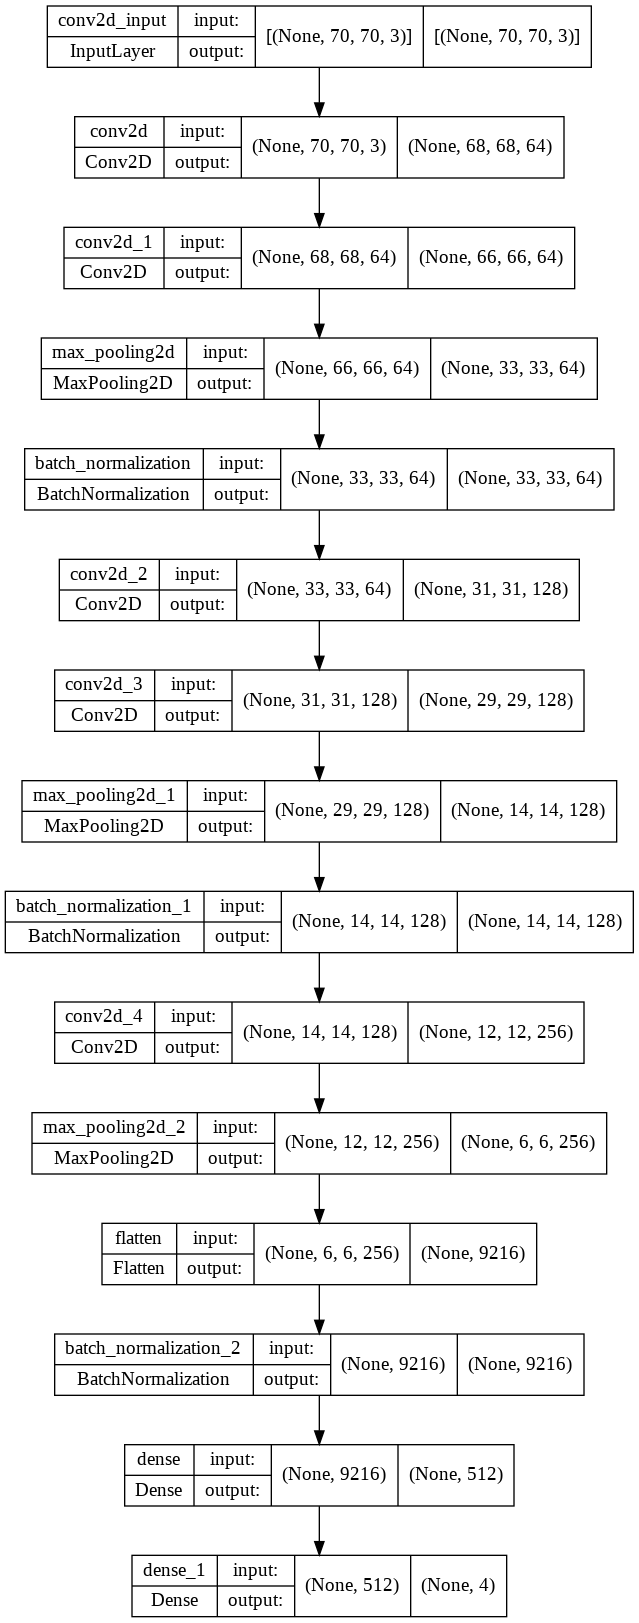

In [ ]:
# Plotting the First CNN Model
plot_model(CNN_Model1, show_shapes=True, show_layer_names=True)

Using "CNN Model - 1" as DL Classification Algorithm:- 


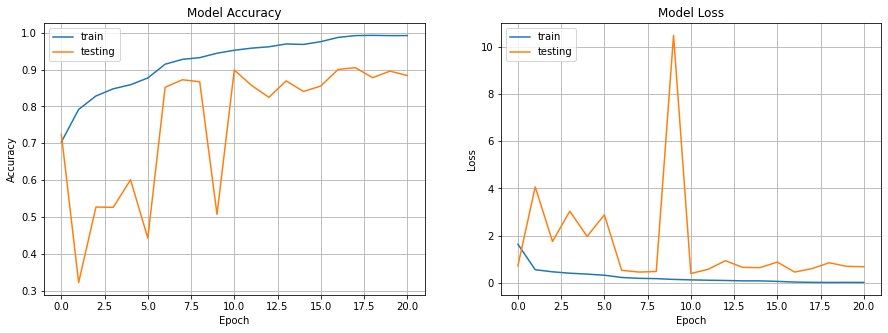

133/133 [==============================] - 2s 18ms/step - loss: 0.6857 - accuracy: 0.8838

Test loss: 0.6857 ~ 68.57%
Test accuracy: 0.8838 ~ 88.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       720
           1       0.87      0.84      0.86      1236
           2       0.90      0.89      0.89      1998
           3       0.96      0.90      0.93       279

    accuracy                           0.88      4233
   macro avg       0.89      0.89      0.89      4233
weighted avg       0.89      0.88      0.88      4233


Confusion Matrix:


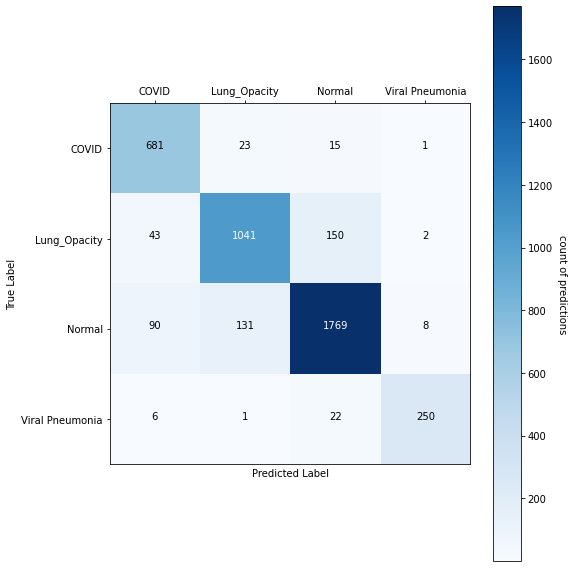



Model Predicted labels vs Original Labels: 


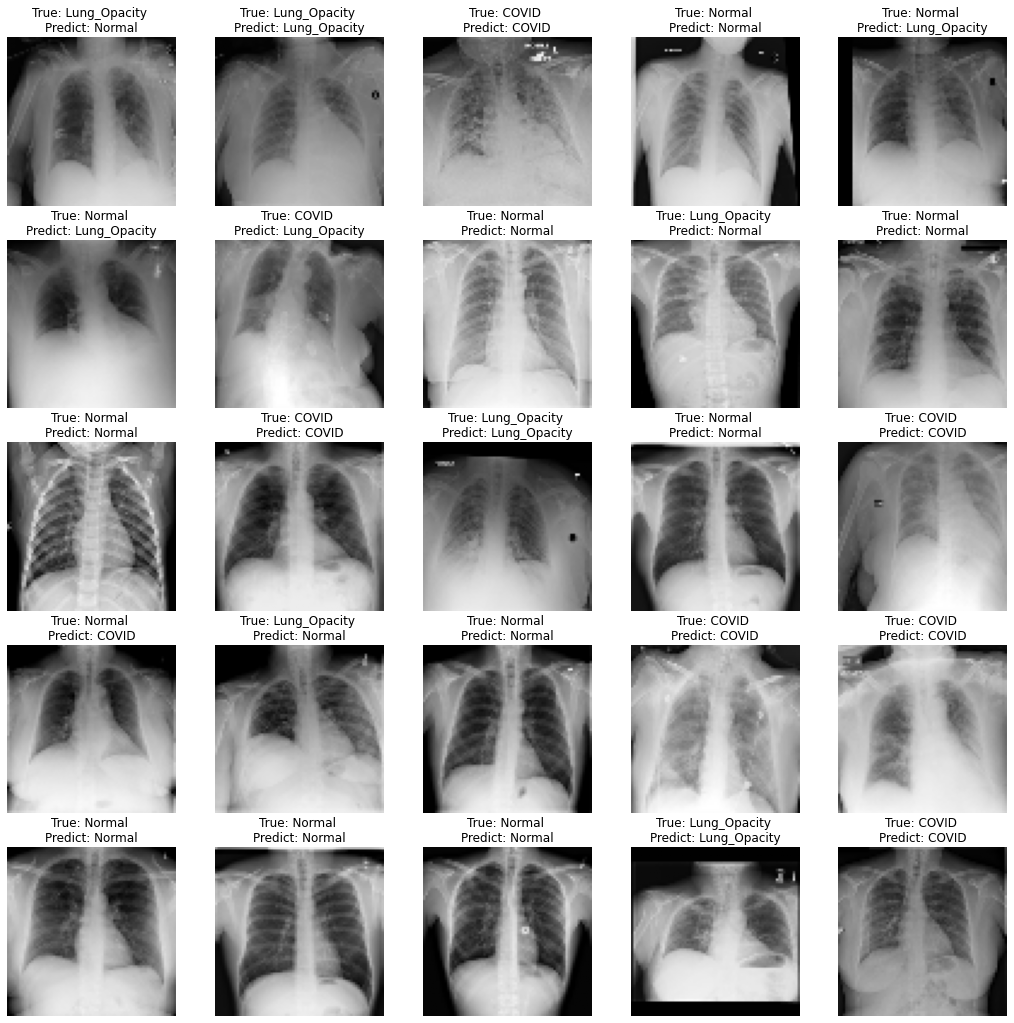

In [ ]:
# Evaluating & Predicting the First CNN Model
CNN_model = CNN_Model1
print("Using \"CNN Model - 1\" as DL Classification Algorithm:- ")
plotmodelhistory(CNN1_history)
model_eval(CNN_model, X_test, y_test_cat)

In [ ]:
# Bulding the Second CNN Model
CNN_Model2 = Sequential()
CNN_Model2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(70, 70, 3)))
CNN_Model2.add(MaxPool2D(pool_size = (2, 2)))
CNN_Model2.add(Conv2D(32, (3, 3), activation="relu"))
CNN_Model2.add(MaxPool2D(pool_size = (2, 2)))

CNN_Model2.add(Conv2D(64, (3, 3), activation="relu"))
CNN_Model2.add(MaxPool2D(pool_size = (2, 2)))
CNN_Model2.add(Conv2D(64, (3, 3), activation="relu"))
CNN_Model2.add(MaxPool2D(pool_size = (2, 2)))

CNN_Model2.add(Flatten())
CNN_Model2.add(Dense(activation = 'relu', units = 128))
CNN_Model2.add(Dense(activation = 'relu', units = 64))
CNN_Model2.add(Dense(activation = 'sigmoid', units = 4))

CNN_Model2.summary()

CNN_Model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 68, 68, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 34, 34, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 7, 7, 64)        

In [ ]:
# MODEL CHECKPOINT - CNN_Model2.h5
modelCheckpoint = ModelCheckpoint(monitor="val_accuracy", 
                      filepath="/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/CNN_Model2.h5", 
                      verbose=1, 
                      save_best_only=True, 
                      mode='auto') 

callBack = [learningRateReduction, earlyStopping, modelCheckpoint]

In [ ]:
# Training the Second CNN Model
CNN2_history=CNN_Model2.fit(X_train,
                  y_train_cat,
                  epochs=50,
                  batch_size=16,
                  validation_data=(X_test,y_test_cat),
                  verbose=1,
                  callbacks=callBack)

Epoch 1/50
1059/1059 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.6627
Epoch 1: val_accuracy improved from -inf to 0.73210, saving model to /content/drive/MyDrive/BestModel/CNN_Model2.h5
1059/1059 [==============================] - 22s 12ms/step - loss: 0.3637 - accuracy: 0.6627 - val_loss: 0.2972 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 2/50
1054/1059 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.7556
Epoch 2: val_accuracy improved from 0.73210 to 0.75998, saving model to /content/drive/MyDrive/BestModel/CNN_Model2.h5
1059/1059 [==============================] - 11s 10ms/step - loss: 0.2783 - accuracy: 0.7556 - val_loss: 0.2652 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 3/50
1058/1059 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.7967
Epoch 3: val_accuracy improved from 0.75998 to 0.80676, saving model to /content/drive/MyDrive/BestModel/CNN_Model2.h5
1059/1059 [==============================] - 12s 11ms/st

In [ ]:
# Loading the Second CNN Model
CNN_Model2 = tf.keras.models.load_model('/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/CNN_Model2.h5')

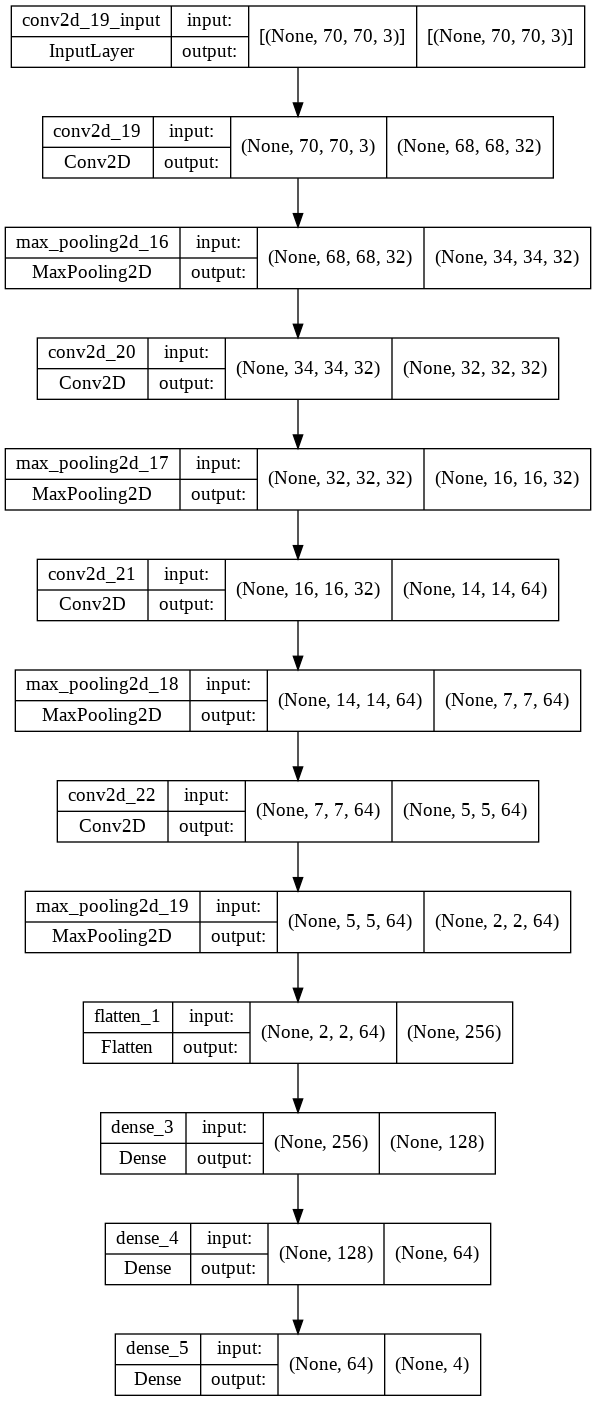

In [ ]:
# Plotting the Second CNN Model
plot_model(CNN_Model2, show_shapes=True, show_layer_names=True)

Using "CNN Model - 2" as DL Classification Algorithm:- 


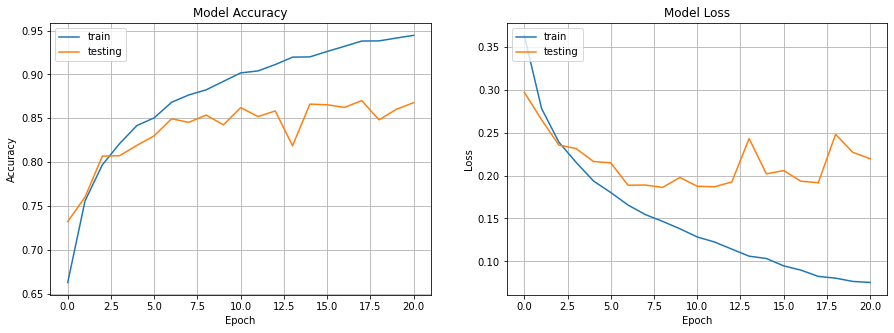

133/133 [==============================] - 1s 7ms/step - loss: 0.2197 - accuracy: 0.8677

Test loss: 0.2197 ~ 21.97%
Test accuracy: 0.8677 ~ 86.77%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84       734
           1       0.85      0.81      0.83      1193
           2       0.90      0.89      0.90      2048
           3       0.94      0.90      0.92       258

    accuracy                           0.87      4233
   macro avg       0.87      0.87      0.87      4233
weighted avg       0.87      0.87      0.87      4233


Confusion Matrix:


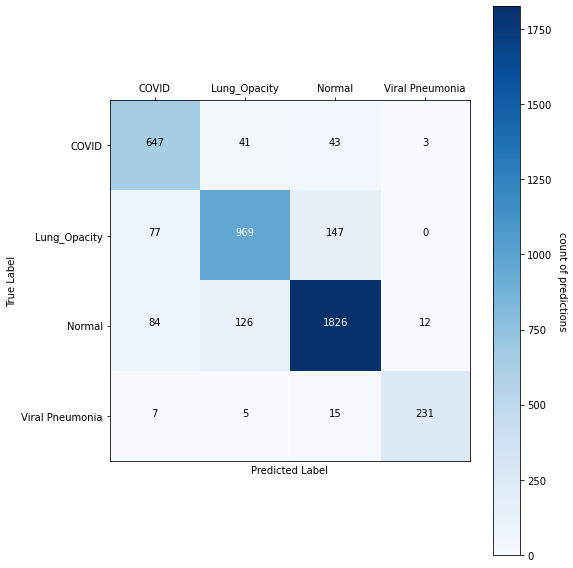



Model Predicted labels vs Original Labels: 


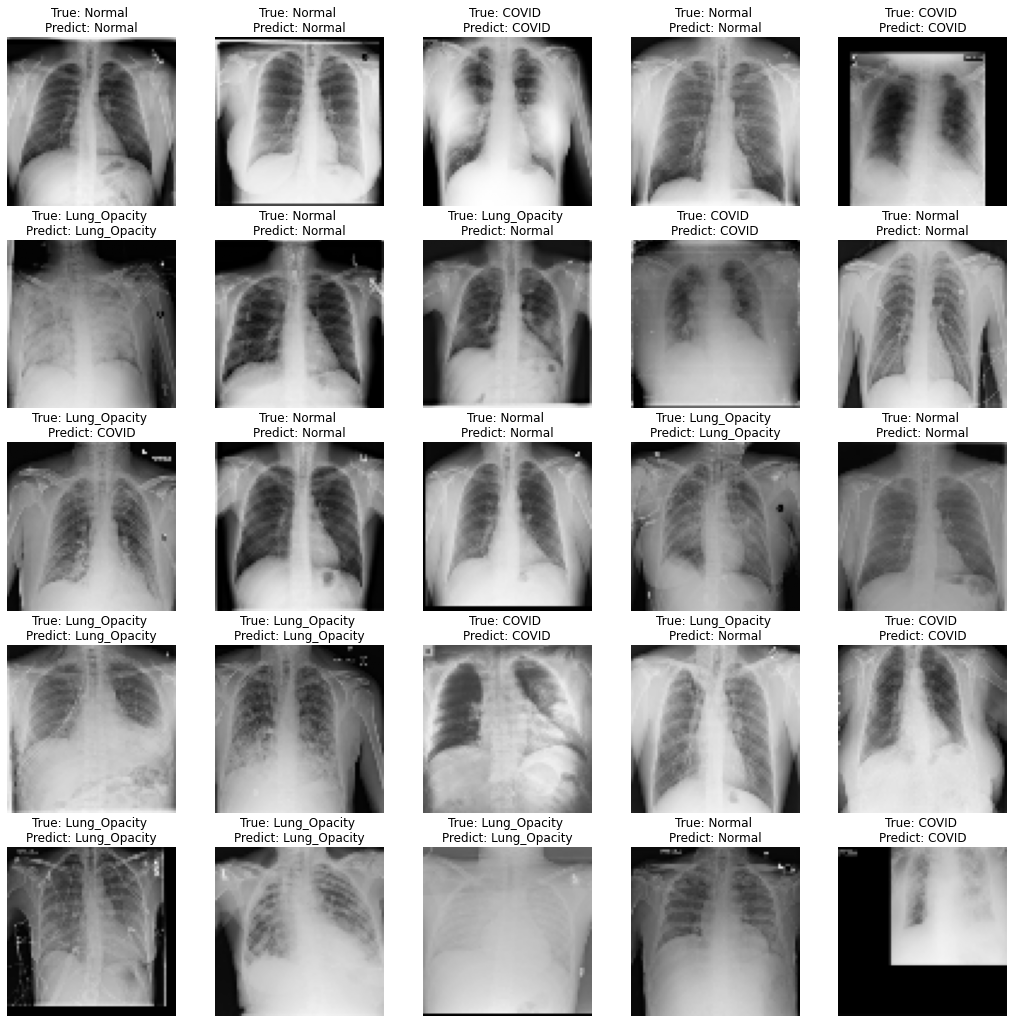

In [ ]:
# Evaluating & Predicting the Second CNN Model
CNN_model = CNN_Model2
print("Using \"CNN Model - 2\" as DL Classification Algorithm:- ")
plotmodelhistory(CNN2_history)
model_eval(CNN_model, X_test, y_test_cat)

In [ ]:
# Sameer Implementation


# Bulding the Third CNN Model                     : CNN_Model3
# MODEL CHECKPOINT                                : /content/drive/MyDrive/BestModel/CNN_Model3.h5
# Training the Third CNN Model                    : CNN3_history=CNN_Model3.fit
# Loading the Third CNN Model                     : CNN_Model3 = tf.keras.models.load_model('/content/drive/MyDrive/BestModel/CNN_Model3.h5')
# Plotting the Third CNN Model                    : plot_model(CNN_Model3, show_shapes=True, show_layer_names=True)
# Evaluating & Predicting the Third CNN Model     : CNN_model = CNN_Model3      &             plotmodelhistory(CNN3_history)

In [ ]:
# Importing the First Resnet Model (Resnet-50)
resnet_model1= tf.keras.applications.ResNet50(
                    include_top=True,
                    weights=None,
                    input_tensor=None,
                    input_shape=(70,70,3),
                    pooling='avg',
                    classes=4)

resnet_model1.summary()

resnet_model1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 76, 76, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 35, 35, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 35, 35, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
# MODEL CHECKPOINT - Resnet_Model1.h5
modelCheckpoint = ModelCheckpoint(monitor="val_accuracy", 
                      filepath="/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/Resnet_Model1.h5", 
                      verbose=1, 
                      save_best_only=True, 
                      mode='auto') 

callBack = [learningRateReduction, earlyStopping, modelCheckpoint]

In [ ]:
# Training the First Resnet Model (Resnet-50)
Resnet1_history=resnet_model1.fit(X_train,
                  y_train_cat,
                  epochs=50,
                  batch_size=16,
                  validation_data=(X_test,y_test_cat),
                  verbose=1,
                  callbacks=callBack)

Epoch 1/50
1059/1059 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.7174
Epoch 1: val_accuracy improved from -inf to 0.58564, saving model to /content/drive/MyDrive/BestModel/Resnet_Model1.h5
1059/1059 [==============================] - 158s 132ms/step - loss: 0.8203 - accuracy: 0.7174 - val_loss: 1.2269 - val_accuracy: 0.5856 - lr: 0.0010
Epoch 2/50
1059/1059 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.8065
Epoch 2: val_accuracy did not improve from 0.58564
1059/1059 [==============================] - 133s 126ms/step - loss: 0.5389 - accuracy: 0.8065 - val_loss: 1.1802 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 3/50
1059/1059 [==============================] - ETA: 0s - loss: 0.4791 - accuracy: 0.8271
Epoch 3: val_accuracy improved from 0.58564 to 0.60123, saving model to /content/drive/MyDrive/BestModel/Resnet_Model1.h5
1059/1059 [==============================] - 137s 129ms/step - loss: 0.4791 - accuracy: 0.8271 - val_loss: 1.2358 

In [ ]:
# Loading the First Resnet Model (Resnet-50)
Resnet_Model1 = tf.keras.models.load_model('/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/Resnet_Model1.h5')

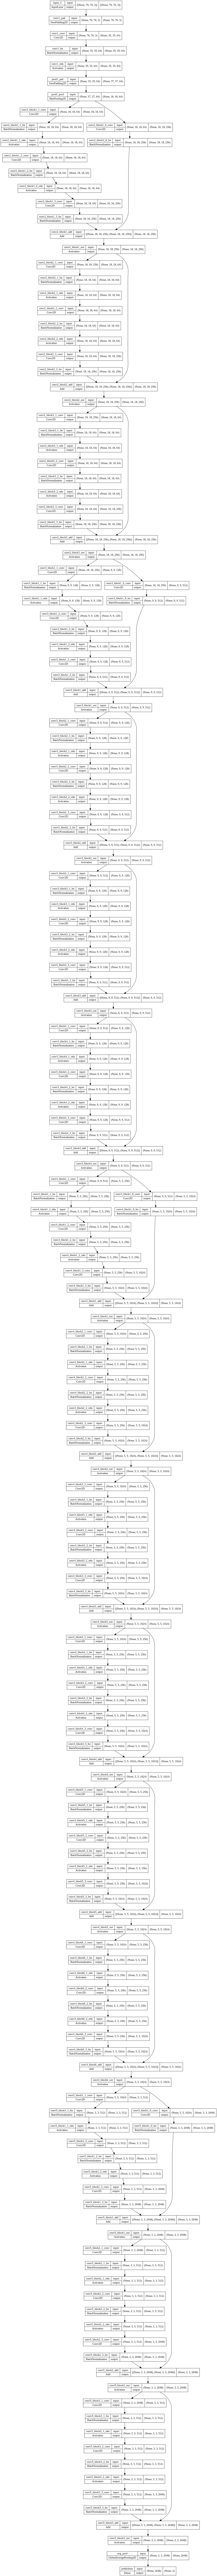

In [ ]:
# Plotting the First Resnet Model (Resnet-50)
plot_model(resnet_model1, show_shapes=True, show_layer_names=True)

Using "Resnet Model - 1" as DL Classification Algorithm:- 


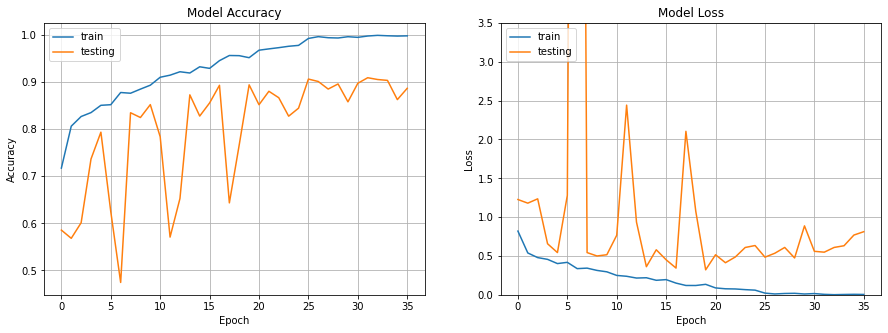

133/133 [==============================] - 7s 51ms/step - loss: 0.8128 - accuracy: 0.8871

Test loss: 0.8128 ~ 81.28%
Test accuracy: 0.8871 ~ 88.71%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       753
           1       0.90      0.78      0.84      1180
           2       0.85      0.95      0.90      2019
           3       0.96      0.95      0.96       281

    accuracy                           0.89      4233
   macro avg       0.92      0.88      0.90      4233
weighted avg       0.89      0.89      0.89      4233


Confusion Matrix:


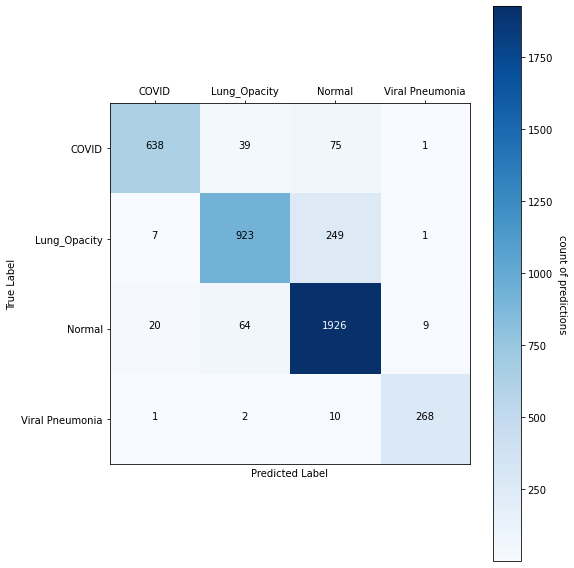



Model Predicted labels vs Original Labels: 


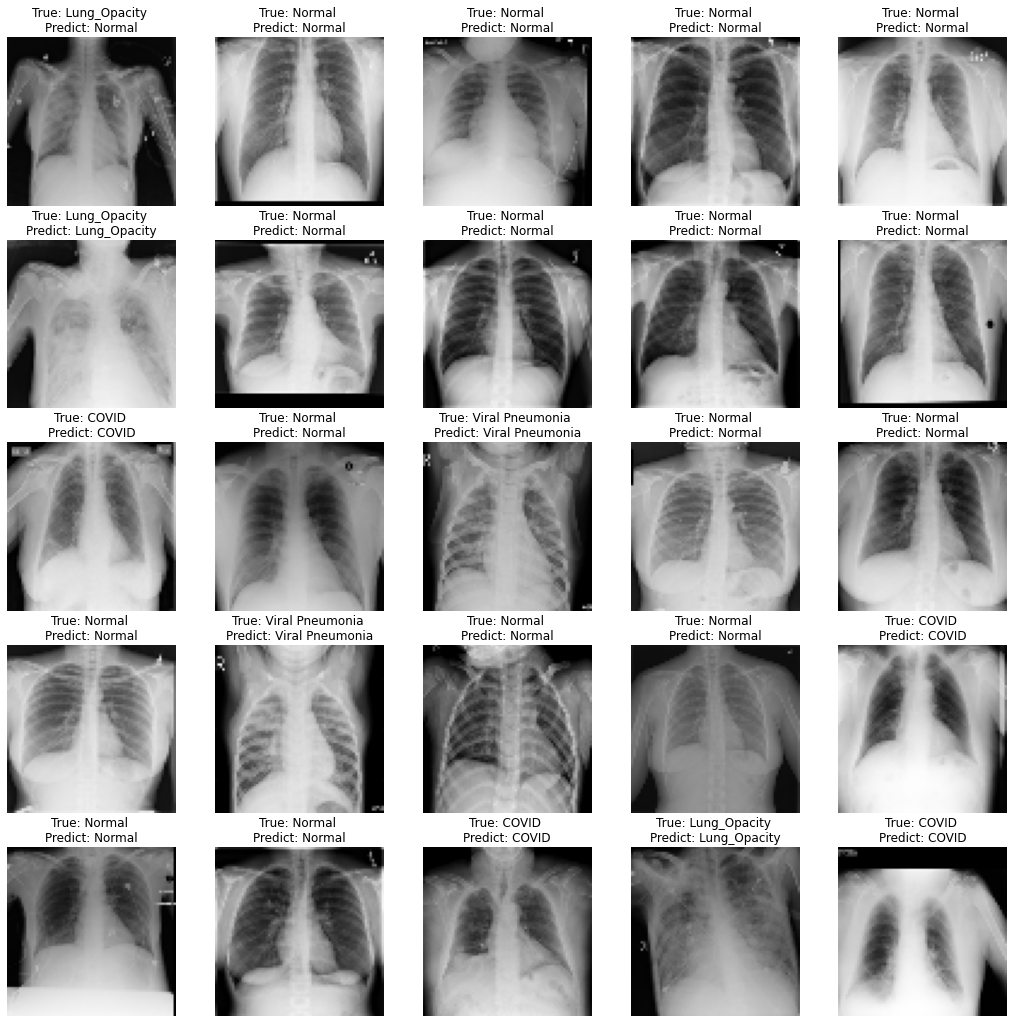

In [ ]:
# Evaluating & Predicting the First Resnet Model (Resnet-50)
CNN_model = resnet_model1
print("Using \"Resnet Model - 1\" as DL Classification Algorithm:- ")
plotmodelhistory(Resnet1_history)
model_eval(CNN_model, X_test, y_test_cat)

In [12]:
# Importing the Second Resnet Model (Resnet-152 V2)
resnet_model2= tf.keras.applications.ResNet152V2(
                    include_top=True,
                    weights=None,
                    input_tensor=None,
                    input_shape=(70,70,3),
                    pooling='avg',
                    classes=4)

resnet_model2.summary()

resnet_model2.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 76, 76, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 35, 35, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 37, 37, 64)   0           ['conv1_conv[0][0]']             
                                                                                        

In [17]:
# MODEL CHECKPOINT - Resnet_Model2.h5
modelCheckpoint = ModelCheckpoint(monitor="val_accuracy", 
                      filepath="/content/drive/MyDrive/BestModel/Resnet_Model2.h5", 
                      verbose=1, 
                      save_best_only=True, 
                      mode='auto') 

callBack = [learningRateReduction, earlyStopping, modelCheckpoint]

In [18]:
# Loading the Second Resnet Model (Resnet-152 V2)
resnet_model2 = tf.keras.models.load_model('/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/Resnet_Model2.h5')

In [19]:
# Training the Second Resnet Model (Resnet-152 V2)
Resnet2_history=resnet_model2.fit(X_train,
                  y_train_cat,
                  epochs=50,
                  batch_size=16,
                  validation_data=(X_test,y_test_cat),
                  verbose=1,
                  callbacks=callBack)

Epoch 1/50
1059/1059 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.9170
Epoch 1: val_accuracy improved from -inf to 0.88448, saving model to /content/drive/MyDrive/BestModel/Resnet_Model2.h5
1059/1059 [==============================] - 367s 326ms/step - loss: 0.2313 - accuracy: 0.9170 - val_loss: 0.3062 - val_accuracy: 0.8845 - lr: 0.0010
Epoch 2/50
1059/1059 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9266
Epoch 2: val_accuracy did not improve from 0.88448
1059/1059 [==============================] - 352s 333ms/step - loss: 0.2021 - accuracy: 0.9266 - val_loss: 0.7941 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 3/50
1059/1059 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9311
Epoch 3: val_accuracy did not improve from 0.88448
1059/1059 [==============================] - 333s 314ms/step - loss: 0.1852 - accuracy: 0.9311 - val_loss: 0.7241 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 4/50
1059/1059 [=============

In [20]:
# Loading the Second Resnet Model (Resnet-152 V2)
Resnet_Model2 = tf.keras.models.load_model('/content/drive/MyDrive/COVID-19_Radiography_Dataset/BestModel/Resnet_Model2.h5')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.529996 to fit



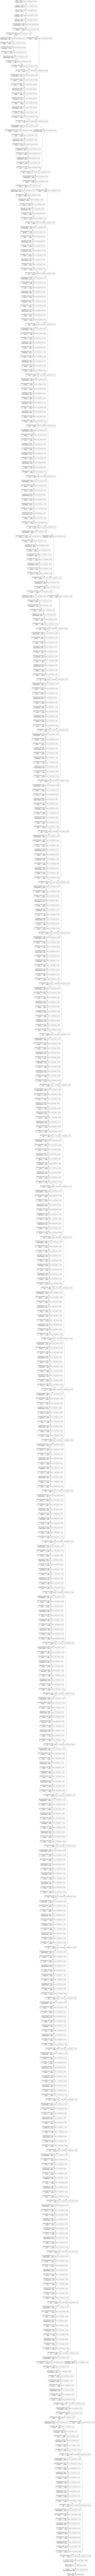

In [21]:
# Plotting the Second Resnet Model (Resnet-152 V2)
plot_model(resnet_model2, show_shapes=True, show_layer_names=True)

Using "Resnet Model - 2" as DL Classification Algorithm:- 


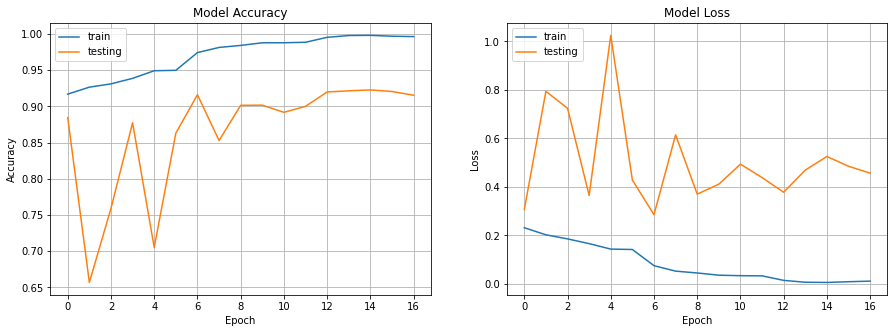

133/133 [==============================] - 17s 122ms/step - loss: 0.4564 - accuracy: 0.9154

Test loss: 0.4564 ~ 45.64%
Test accuracy: 0.9154 ~ 91.54%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       776
           1       0.87      0.87      0.87      1174
           2       0.93      0.91      0.92      2011
           3       0.96      0.98      0.97       272

    accuracy                           0.92      4233
   macro avg       0.92      0.93      0.93      4233
weighted avg       0.92      0.92      0.92      4233


Confusion Matrix:


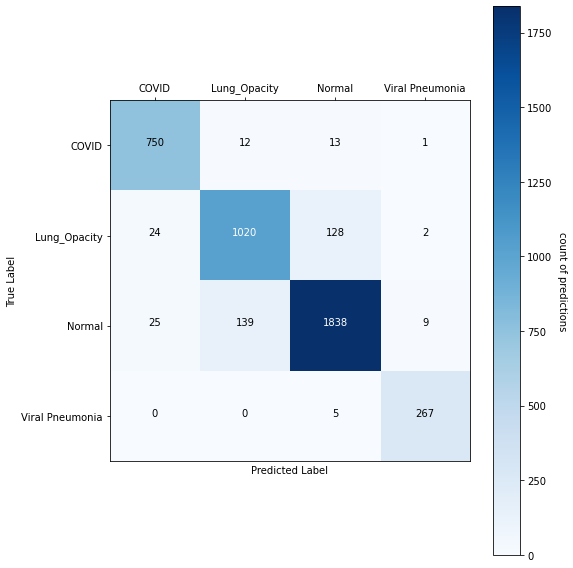



Model Predicted labels vs Original Labels: 


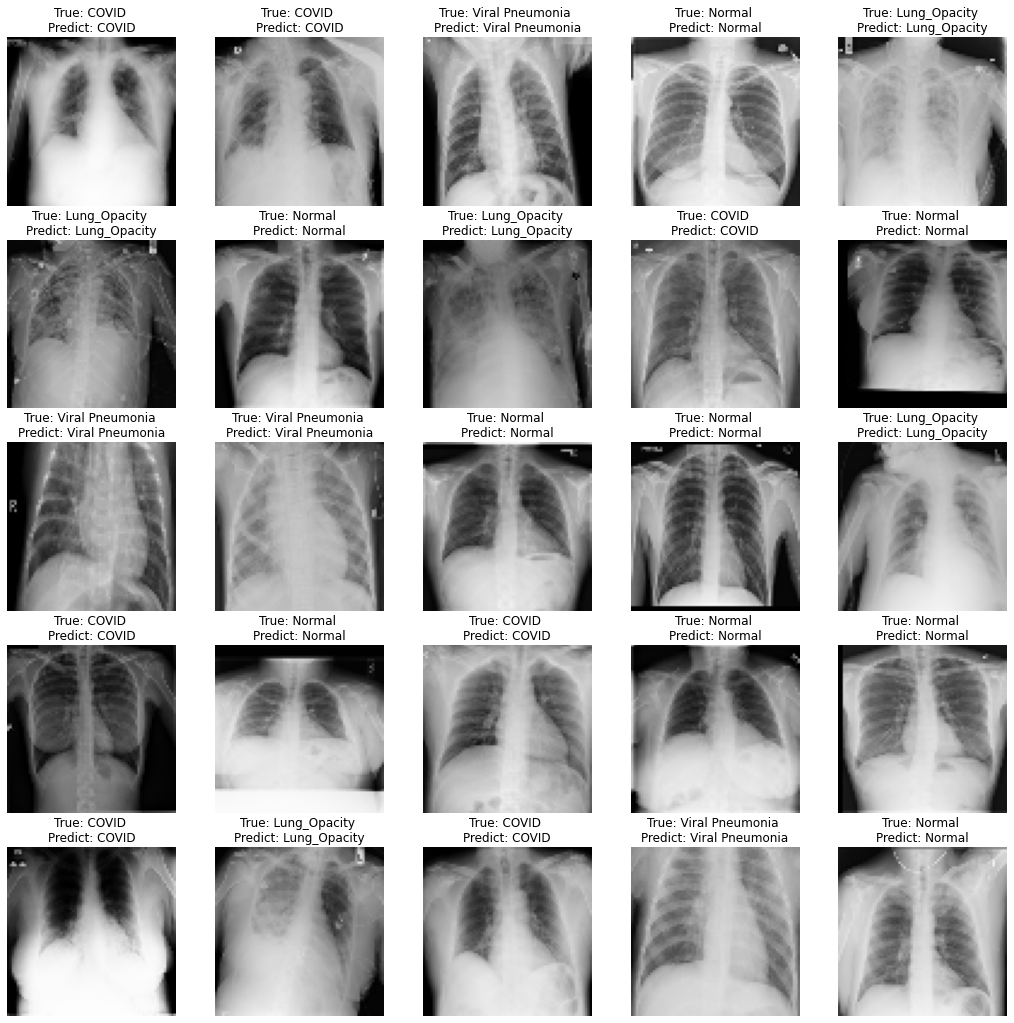

In [22]:
# Evaluating & Predicting the Second Resnet Model (Resnet-152 V2)
CNN_model = resnet_model2
print("Using \"Resnet Model - 2\" as DL Classification Algorithm:- ")
plotmodelhistory(Resnet2_history)
model_eval(CNN_model, X_test, y_test_cat)